## Import Libraries

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D
from transformers import BertModel, BertTokenizer
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

#### Pip installs for efficent net

In [1]:
pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

# Data loading

In [3]:
import gdown

file_url = "https://drive.google.com/uc?id=10WknIwgZsduZnPTYUHqjhcu-KKjRUUuU"

# Define the output filename
output_zip = "song_snap.zip"

# Download the file
gdown.download(file_url, output_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=10WknIwgZsduZnPTYUHqjhcu-KKjRUUuU
From (redirected): https://drive.google.com/uc?id=10WknIwgZsduZnPTYUHqjhcu-KKjRUUuU&confirm=t&uuid=00a3841f-1fe2-4598-a488-839020c948b1
To: /content/song_snap.zip
100%|██████████| 491M/491M [00:02<00:00, 202MB/s]


'song_snap.zip'

In [4]:
# !unzip "/content/drive/MyDrive/Songsnap/songsnap_data" -d .
!unzip "/content/song_snap.zip" -d .

Archive:  /content/song_snap.zip
   creating: ./songsnap_data/
  inflating: ./songsnap_data/.DS_Store  
  inflating: ./__MACOSX/songsnap_data/._.DS_Store  
  inflating: ./songsnap_data/X_image_spectogram.npy  
  inflating: ./__MACOSX/songsnap_data/._X_image_spectogram.npy  
  inflating: ./songsnap_data/X_lyrics.npy  
  inflating: ./__MACOSX/songsnap_data/._X_lyrics.npy  
  inflating: ./songsnap_data/targets.csv  
  inflating: ./__MACOSX/songsnap_data/._targets.csv  
  inflating: ./songsnap_data/X_sound.csv  
  inflating: ./__MACOSX/songsnap_data/._X_sound.csv  


In [5]:
!ls

__MACOSX  sample_data  songsnap_data  song_snap.zip


In [6]:
folder_contents = os.listdir("songsnap_data")

print("Contents of the folder:")
for item in folder_contents:
    print(item)

Contents of the folder:
X_lyrics.npy
targets.csv
X_image_spectogram.npy
X_sound.csv
.DS_Store


### Loading Features for Sound, Spectogram, and Lyrics

In [7]:
X_sound = pd.read_csv("./songsnap_data/X_sound.csv")

In [8]:

X_sound.shape

(5006, 31)

In [9]:
num_columns_X_sound = X_sound.shape[1]

In [10]:
X_image_spectogram = np.load("./songsnap_data/X_image_spectogram.npy")

In [14]:
X_image_spectogram.shape

(5006, 224, 224, 3)

In [15]:
X_lyrics = np.load("./songsnap_data/X_lyrics.npy")

In [16]:
X_lyrics.shape

(5006,)

In [17]:
y = pd.read_csv("./songsnap_data/targets.csv")

In [18]:
y.shape

(5006, 22)

In [19]:
y["popularity"] = y["target"]

In [22]:
y.head()

,file,Unnamed: 0,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tempo,duration_ms,time_signature,chorus_hit,sections,target,bucket,genre,lyrics,popularity
0,BeiNacht-RioReiser,12991,spotify:track:1uHwyibZtAYFwtFuRboomt,0.648,0.243,9,-16.473,1,0.0395,0.39400,...,121.318,365200,4,61.45136,12,0,BeiNacht-RioReiser.wav,r&b,2 ContributorsBei Nacht Lyrics[Strophe I:]\nOh...,0
1,RetratoEmBrancoePreto-ChicoBuarque,1211,spotify:track:2SddU3HytJdbjTqSNVasY6,0.493,0.462,2,-8.773,1,0.0306,0.62400,...,104.237,199067,3,56.13959,9,0,RetratoEmBrancoePreto-ChicoBuarque.wav,pop,4 ContributorsRetrato em Branco e Preto Lyrics...,0
2,Disorder-2007Remaster-JoyDivision,7311,spotify:track:5fbQCQt91LsVgXusFS0CCD,0.320,0.798,10,-7.078,0,0.1240,0.00033,...,84.696,209040,4,19.35025,8,0,Disorder-2007Remaster-JoyDivision.wav,rock,3 ContributorsReflections on the Revolution in...,0
3,BonnieAndClyde-VermillionLies,27605,spotify:track:6YFtkgjVwyu74TS5eBvnVN,0.566,0.355,4,-8.261,1,0.0961,0.92500,...,82.260,166853,4,41.20301,9,0,BonnieAndClyde-VermillionLies.wav,pop,1 ContributorBonnie and clyde LyricsMy Dear Cl...,0
4,TurningWorld-SteveRoach,21476,spotify:track:2NZ8RIm64njysnW6OceMuO,0.510,0.422,8,-23.591,1,0.0366,0.64200,...,89.456,463840,4,32.64560,21,0,TurningWorld-SteveRoach.wav,r&b,1 ContributorBismuth Lyrics[Open Int. Beach Ho...,0


In [23]:
y_genre = []
y_popularity = []
y_danceability =[]
y_energy = []

for index, row in y.iterrows():
    y_popularity.append(row["popularity"])
    y_genre.append((row["genre"]))
    y_danceability.append(row["danceability"])
    y_energy.append(row["energy"])


In [24]:
y_genre = np.array(y_genre)
y_popularity = np.array(y_popularity)
y_danceability = np.array(y_danceability)
y_energy = np.array(y_energy)

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_genre = label_encoder.fit_transform(y_genre)

In [26]:
num_unique_genres = len(label_encoder.classes_)
print(num_unique_genres)

7


# Train-test split

In [27]:
total_elements = len(X_sound)
total_elements

5006

In [28]:
import random
num_test_indices = int(0.20 * total_elements)
test_indices = random.sample(range(total_elements), num_test_indices)
train_indices = [i for i in range(total_elements) if i not in test_indices]
print(len(test_indices))
print(len(train_indices))

1001
4005


In [29]:
X_sound_train = X_sound.iloc[train_indices]
X_image_spectogram_train = X_image_spectogram[train_indices]
# X_image_album_train = X_image_album[train_indices]
X_lyrics_train = X_lyrics[train_indices]


X_sound_test = X_sound.iloc[test_indices]
X_image_spectogram_test = X_image_spectogram[test_indices]
# X_image_album_test = X_image_album[test_indices]
X_lyrics_test = X_lyrics[test_indices]

In [30]:
y_genre_train = [y_genre[i] for i in train_indices]
y_popularity_train = [y_popularity[i] for i in train_indices]
y_danceability_train = [y_danceability[i] for i in train_indices]
y_energy_train = [y_energy[i] for i in train_indices]

y_genre_test = [y_genre[i] for i in test_indices]
y_popularity_test = [y_popularity[i] for i in test_indices]
y_danceability_test = [y_danceability[i] for i in test_indices]
y_energy_test = [y_energy[i] for i in test_indices]

# Model Definition - UnFrozen Weights for Text

In [31]:
import torch

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [33]:
device

device(type='cuda')

In [34]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

# SoundModalityModel creates the sound embeddings based on the SLP features
class SoundModalityModel(nn.Module):
    def __init__(self, num_columns_X_sound):
        super(SoundModalityModel, self).__init__()
        self.sound_embedding = nn.Sequential(
            nn.Linear(num_columns_X_sound, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU()
        )

    def forward(self, input_sound):
        sound_embedding = self.sound_embedding(input_sound)
        return sound_embedding


class ImageModalityModel(nn.Module):
    def __init__(self, embedding_size=8):
        super(ImageModalityModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        for param in self.efficientnet.parameters():
            param.requires_grad = False


        # Replace the final fully connected layer with a new one
        self.efficientnet._fc = nn.Linear(self.efficientnet._fc.in_features, embedding_size)

    def forward(self, input_image):
        # Forward pass through EfficientNet
        output = self.efficientnet(input_image)
        return output


class TextModalityModel(nn.Module):
    def __init__(self, embedding_size=8, freeze_bert=True):
        super(TextModalityModel, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze the BERT weights if freeze_bert is True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        for param in self.bert.encoder.layer[-3:].parameters():
                param.requires_grad = True

        # Maps to size 8 embedding
        self.fc = nn.Linear(self.bert.config.hidden_size, embedding_size)

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through BERT
        outputs = self.bert(input_ids, attention_mask=attention_mask)

        # Extract the last hidden states
        last_hidden_states = outputs.last_hidden_state

        # Take the mean of the last hidden states (reduce it to 1 dimension)
        mean_last_hidden_state = torch.mean(last_hidden_states, dim=1)

        # Pass the mean last hidden states through the fully connected layer (maps to size 8 embedding)
        output = self.fc(mean_last_hidden_state)

        return output



# Overall model that combines the embeddings from the three modalities and produces 4 outputs
# Separate fully connected layers for genre, popularity, danceability, and energy
class OverallModel(nn.Module):
    def __init__(self, num_modalities, num_genres):
        super(OverallModel, self).__init__()
        self.concatenated_output_size = 8 * num_modalities
        self.fc1 = nn.Linear(self.concatenated_output_size, 64)
        self.fc2_genre = nn.Linear(64, num_genres)
        self.fc3_popularity = nn.Linear(64, 1)
        self.fc4_danceability = nn.Linear(64, 1)
        self.fc5_energy = nn.Linear(64, 1)

    def forward(self, sound_embedding, spec_embedding, text_embedding):
        concatenated_embedding = torch.cat((sound_embedding, spec_embedding, text_embedding), dim=1)

        x = torch.relu(self.fc1(concatenated_embedding))
        genre_output = torch.softmax(self.fc2_genre(x), dim=-1)
        popularity_output = torch.sigmoid(self.fc3_popularity(x))
        danceability_output = torch.sigmoid(self.fc4_danceability(x))
        energy_output = torch.sigmoid(self.fc5_energy(x))
        return genre_output, popularity_output, danceability_output, energy_output

num_modalities = 3 
num_genres = num_unique_genres

sound_model = SoundModalityModel(num_columns_X_sound).to(device)
spec_model = ImageModalityModel().to(device)
text_model = TextModalityModel().to(device)

overall_model = OverallModel(num_modalities, num_genres).to(device)


# Create optimizers for each of our models (modality models as well as genre, popularity, danceability, energy)
optimizer_sound = optim.Adam(sound_model.parameters())
optimizer_spec = optim.Adam(spec_model.parameters())

optimizer_genre = optim.Adam(overall_model.fc2_genre.parameters())
optimizer_popularity = optim.Adam(overall_model.fc3_popularity.parameters())
optimizer_danceability = optim.Adam(overall_model.fc4_danceability.parameters())
optimizer_energy = optim.Adam(overall_model.fc5_energy.parameters())

# Define the criteria
criterion_genre = nn.CrossEntropyLoss()
criterion_popularity = nn.BCELoss()
criterion_danceability = nn.MSELoss()
criterion_energy = nn.MSELoss()

# Compile our datasets
X_sound_train = torch.tensor(X_sound_train.values, dtype=torch.float32).to(device)
X_spec_train = torch.tensor(X_image_spectogram_train, dtype=torch.float32).to(device)
X_lyrics_train = X_lyrics_train.tolist()
y_genre_train = torch.tensor(y_genre_train, dtype=torch.long).to(device)
y_danceability_train = torch.tensor(y_danceability_train, dtype=torch.float32).to(device)
y_popularity_train = torch.tensor(y_popularity_train, dtype=torch.float32).to(device)
y_energy_train = torch.tensor(y_energy_train, dtype=torch.float32).to(device)

# Define basic parameters before training
num_epochs = 10
batch_size = 32
num_training_samples = 5006 * 0.8
num_training_batches = int(num_training_samples // batch_size)

num_test_samples = 5006 - num_training_samples
num_testing_batches = int(num_test_samples // batch_size)

losses_genre = []
losses_popularity = []
losses_danceability = []
losses_energy = []

# Training loop
for epoch in range(num_epochs):
    for batch in range(num_training_batches):
        start = batch * batch_size
        end = min(start + batch_size, num_training_samples)

        # Get data for this batch
        batch_X_sound = X_sound_train[start:end]
        batch_X_spec = X_spec_train[start:end]
        batch_X_spec = batch_X_spec.permute(0, 3, 1, 2)

        batch_X_lyric = X_lyrics_train[start:end]

        max_length = max([len(text_model.tokenizer.encode(text)) for text in batch_X_lyric])
        tokenized_sequences = [text_model.tokenizer.encode(text, padding='max_length', max_length=text_model.tokenizer.model_max_length, truncation=True) for text in batch_X_lyric]

        # Generate attention masks
        attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in tokenized_sequences]

        # Convert tokenized sequences and attention masks to tensors and move to device
        batch_X_lyric = torch.tensor(tokenized_sequences, dtype=torch.long).to(device)
        attention_masks = torch.tensor(attention_masks, dtype=torch.long).to(device)

        batch_y_genre = y_genre_train[start:end]
        batch_y_popularity = y_popularity_train[start:end]
        batch_y_danceability = y_danceability_train[start:end]
        batch_y_energy = y_energy_train[start:end]


        # Zero the gradients
        optimizer_sound.zero_grad()
        optimizer_spec.zero_grad()


        optimizer_genre.zero_grad()
        optimizer_popularity.zero_grad()
        optimizer_danceability.zero_grad()
        optimizer_energy.zero_grad()

        # Retrieve the four outputs given our embeddings
        sound_embedding = sound_model(batch_X_sound)
        spec_embedding = spec_model(batch_X_spec)
        text_embedding = text_model(batch_X_lyric, attention_masks)


        genre_output, popularity_output, danceability_output, energy_output = overall_model(sound_embedding,
                                                                        spec_embedding,
                                                                        text_embedding)

        genre_output = genre_output.to(device)
        batch_y_genre = batch_y_genre.to(device)

        loss_genre = criterion_genre(genre_output, batch_y_genre.long())
        loss_popularity = criterion_popularity(popularity_output.view(-1), batch_y_popularity)
        loss_danceability = criterion_danceability(danceability_output.view(-1), batch_y_danceability)
        loss_energy = criterion_energy(energy_output.view(-1), batch_y_energy)

        # Backpropagate through the genre, popularity, danceability, and energy layers using their respective losses
        # We retain graph because we are using the computation graph for multiple backprops
        loss_genre.backward(retain_graph=True)
        optimizer_genre.step()

        loss_popularity.backward(retain_graph=True)
        optimizer_popularity.step()

        loss_danceability.backward(retain_graph=True)
        optimizer_danceability.step()

        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()

        # Backpropagate through the sound modality model using the total loss
        optimizer_sound.step()
        optimizer_spec.step()
        # optimizer_album.step()

    losses_genre.append(loss_genre.item())
    losses_popularity.append(loss_popularity.item())
    losses_danceability.append(loss_danceability.item())
    losses_energy.append(loss_energy.item())

    print("Epoch " + str(epoch+1))
    print("Genre loss: " + str(loss_genre.item()))
    print("Popularity loss: " + str(loss_popularity.item()))
    print("Danceability loss: " + str(loss_danceability.item()))
    print("Energy loss: " + str(loss_energy.item()))
    print("")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 174MB/s]


Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<class 'pandas.core.frame.DataFrame'>


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Epoch 1
Genre loss: 1.7875303030014038
Popularity loss: 0.6062850952148438
Danceability loss: 0.01985771954059601
Energy loss: 0.019587364047765732

Epoch 2
Genre loss: 1.790001392364502
Popularity loss: 0.5675475597381592
Danceability loss: 0.02195042558014393
Energy loss: 0.017878293991088867

Epoch 3
Genre loss: 1.770948886871338
Popularity loss: 0.507204532623291
Danceability loss: 0.018961645662784576
Energy loss: 0.017252106219530106

Epoch 4
Genre loss: 1.7808856964111328
Popularity loss: 0.5262203216552734
Danceability loss: 0.02025255374610424
Energy loss: 0.017378054559230804

Epoch 5
Genre loss: 1.7508330345153809
Popularity loss: 0.48380136489868164
Danceability loss: 0.01764984428882599
Energy loss: 0.01593385636806488

Epoch 6
Genre loss: 1.7549335956573486
Popularity loss: 0.5269676446914673
Danceability loss: 0.01826636865735054
Energy loss: 0.01726817712187767

Epoch 7
Genre loss: 1.735031247138977
Popularity loss: 0.4672209620475769
Danceability loss: 0.01508024707436

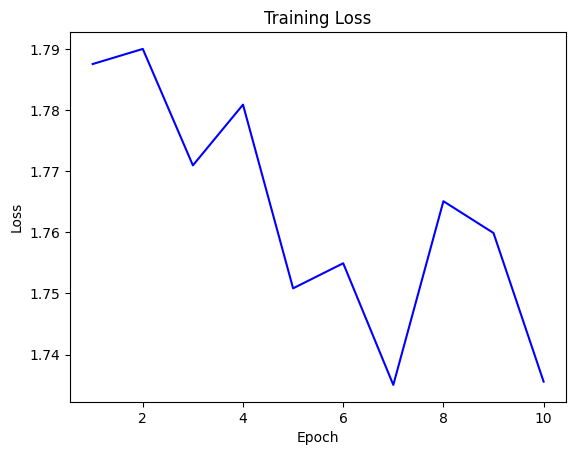

In [36]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

plt.plot(epochs, losses_genre, label='Genre', color='blue')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Show the plot
plt.show()

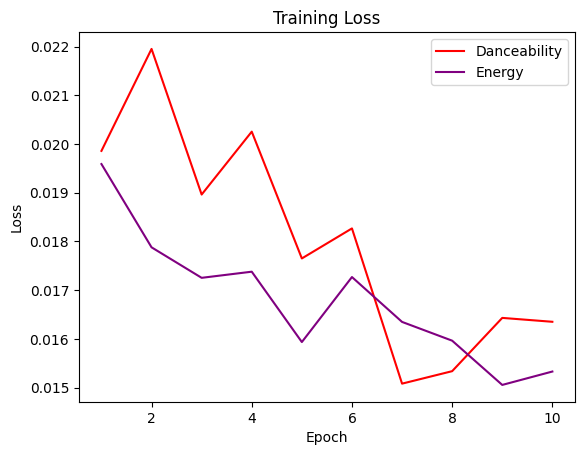

In [37]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

plt.plot(epochs, losses_danceability, label='Danceability', color='red')
plt.plot(epochs, losses_energy, label='Energy', color='purple')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plot
plt.show()

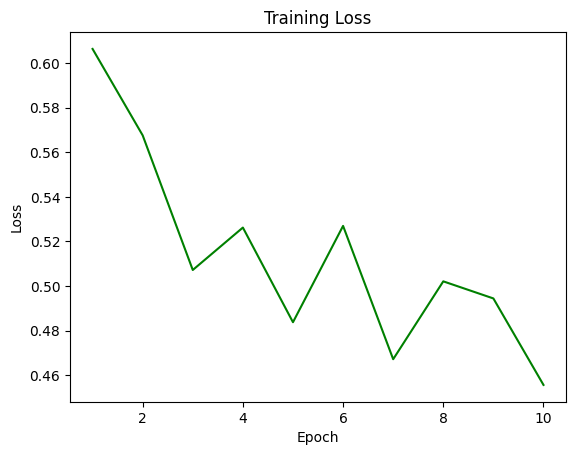

In [38]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

plt.plot(epochs, losses_popularity, label='Popularity', color='green')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Show the plot
plt.show()

# Test loop

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [40]:
import pandas as pd

# Create empty lists to store the outputs
all_genre_outputs = []
all_popularity_outputs = []
all_danceability_outputs = []
all_energy_outputs = []

X_sound_test = torch.tensor(X_sound_test.values, dtype=torch.float32).to(device)
X_spec_test = torch.tensor(X_image_spectogram_test, dtype=torch.float32).to(device)
# X_album_test = torch.tensor(X_image_album_test, dtype=torch.float32).to(device)
X_lyrics_test = X_lyrics_test.tolist()
y_genre_test = torch.tensor(y_genre_test, dtype=torch.long).to(device)
y_danceability_test = torch.tensor(y_danceability_test, dtype=torch.float32).to(device)
y_popularity_test = torch.tensor(y_popularity_test, dtype=torch.float32).to(device)
y_energy_test = torch.tensor(y_energy_test, dtype=torch.float32).to(device)

# Evaluation loop
with torch.no_grad():  # Disable gradient calculation
    overall_model.eval()  # Set the model to evaluation mode
    total_loss_genre = 0
    total_loss_popularity = 0
    total_loss_danceability = 0
    total_loss_energy = 0
    num_batches = 0

    total_accuracy_genre = 0
    total_precision_genre = 0
    total_recall_genre = 0
    total_f1_genre = 0


    total_accuracy_pop = 0
    total_precision_pop = 0
    total_recall_pop =0
    total_f1_pop =0

    for batch in range(num_testing_batches):
        start = batch * batch_size
        end = min(start + batch_size, num_test_samples)

        # Get data for this batch
        batch_X_sound = X_sound_test[start:end]
        # batch_X_album = X_album_test[start:end]
        batch_X_spec = X_spec_test[start:end]
        batch_X_spec = batch_X_spec.permute(0, 3, 1, 2)

        batch_X_lyric = X_lyrics_test[start:end]

        max_length = max([len(text_model.tokenizer.encode(text)) for text in batch_X_lyric])
        tokenized_sequences = [text_model.tokenizer.encode(text, padding='max_length', max_length=text_model.tokenizer.model_max_length, truncation=True) for text in batch_X_lyric]

        # Generate attention masks
        attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in tokenized_sequences]

        # Convert tokenized sequences and attention masks to tensors and move to device
        batch_X_lyric = torch.tensor(tokenized_sequences, dtype=torch.long).to(device)
        attention_masks = torch.tensor(attention_masks, dtype=torch.long).to(device)

        batch_y_genre = y_genre_test[start:end]
        batch_y_popularity = y_popularity_test[start:end]
        batch_y_danceability = y_danceability_test[start:end]
        batch_y_energy = y_energy_test[start:end]

        # Forward pass
        sound_embedding = sound_model(batch_X_sound)
        # album_embedding = album_model(batch_X_album)
        spec_embedding = spec_model(batch_X_spec)
        text_embedding = text_model(batch_X_lyric, attention_masks)

        genre_output, popularity_output, danceability_output, energy_output = overall_model(sound_embedding,
                                                                                            # album_embedding
                                                                                            spec_embedding,
                                                                                            text_embedding)



        # Calculate loss
        loss_genre = criterion_genre(genre_output, batch_y_genre.long())
        loss_popularity = criterion_popularity(popularity_output.view(-1), batch_y_popularity)
        loss_danceability = criterion_danceability(danceability_output.view(-1), batch_y_danceability)
        loss_energy = criterion_energy(energy_output.view(-1), batch_y_energy)

        total_loss_genre += loss_genre.item()
        total_loss_popularity += loss_popularity.item()
        total_loss_danceability += loss_danceability.item()
        total_loss_energy += loss_energy.item()


        # Calculating predicted genre label and popularity
        _, preds_genre  = torch.max(genre_output, 1)
        total_accuracy_genre += accuracy_score(preds_genre.cpu(), batch_y_genre.long().cpu())
        total_precision_genre += precision_score(preds_genre.cpu(), batch_y_genre.long().cpu(), average = 'macro')
        total_recall_genre += recall_score(preds_genre.cpu(), batch_y_genre.long().cpu(), average = 'macro')
        total_f1_genre += f1_score(preds_genre.cpu(), batch_y_genre.long().cpu(), average = 'macro')

        _, preds_pop = torch.max(popularity_output, 1)
        total_accuracy_pop += accuracy_score(preds_pop.cpu(), batch_y_popularity.cpu())
        total_precision_pop += precision_score(preds_pop.cpu(), batch_y_popularity.cpu(), average = 'macro')
        total_recall_pop += recall_score(preds_pop.cpu(), batch_y_popularity.cpu(), average = 'macro')
        total_f1_pop += f1_score(preds_pop.cpu(), batch_y_popularity.cpu(), average = 'macro')

        # Save the outputs to lists
        all_genre_outputs.extend(preds_genre.cpu().numpy())
        all_popularity_outputs.extend(preds_pop.cpu().numpy())
        all_danceability_outputs.extend(danceability_output.cpu().numpy())
        all_energy_outputs.extend(energy_output.cpu().numpy())

        num_batches += 1

    # Calculate average loss
    avg_loss_genre = total_loss_genre / num_batches
    avg_loss_popularity = total_loss_popularity / num_batches
    avg_loss_danceability = total_loss_danceability / num_batches
    avg_loss_energy = total_loss_energy / num_batches

    avg_acc_genre = total_accuracy_genre / num_batches
    avg_precision_genre = total_precision_genre / num_batches
    avg_recall_genre = total_recall_genre / num_batches
    avg_f1_genre = total_f1_genre / num_batches

    avg_acc_pop = total_accuracy_pop / num_batches
    avg_precision_pop = total_precision_pop / num_batches
    avg_recall_pop = total_recall_pop / num_batches
    avg_f1_pop = total_f1_pop / num_batches

    # Calculate the average accuracy, recall, precision and F1 score for genre & popularity


    print("Evaluation Results:")
    print("Average Genre loss: {:.4f}".format(avg_loss_genre))
    print("Average Popularity loss: {:.4f}".format(avg_loss_popularity))
    print("Average Danceability loss: {:.4f}".format(avg_loss_danceability))
    print("Average Energy loss: {:.4f}".format(avg_loss_energy))

    print(" ")
    print("Average Accuracy Popularity: {:.4f}".format(avg_acc_pop))
    print("Average Precision Popularity: {:.4f}".format(avg_precision_pop))
    print("Average Recall Popularity: {:.4f}".format(avg_recall_pop))
    print("Average F1 Popularity: {:.4f}".format(avg_f1_pop))

    print(" ")
    print("Average Accuracy Genre: {:.4f}".format(avg_acc_genre))
    print("Average Precision Genre: {:.4f}".format(avg_precision_genre))
    print("Average Recall Genre: {:.4f}".format(avg_recall_genre))
    print("Average F1 Genre: {:.4f}".format(avg_f1_genre))



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

Evaluation Results:
Average Genre loss: 1.7065
Average Popularity loss: 0.6173
Average Danceability loss: 0.0215
Average Energy loss: 0.0314
 
Average Accuracy Popularity: 0.5071
Average Precision Popularity: 0.5000
Average Recall Popularity: 0.2535
Average F1 Popularity: 0.3340
 
Average Accuracy Genre: 0.4536
Average Precision Genre: 0.2846
Average Recall Genre: 0.2389
Average F1 Genre: 0.2462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Create a DataFrame to store the outputs

results_df = pd.DataFrame({
    'song_name' : y['file'][test_indices[0:len(all_genre_outputs)]],
    'genre_output': all_genre_outputs,
    'popularity_output': all_popularity_outputs,
    'danceability_output': all_danceability_outputs,
    'energy_output': all_energy_outputs
})

In [42]:
results_df.head()

,song_name,genre_output,popularity_output,danceability_output,energy_output
113,MoreThanToast-TheMr.TExperience,6,0,[0.4113208],[0.88421047]
4586,SetMeFree-TheKinks,3,0,[0.5991453],[0.61052924]
3360,TheComancheros-ClaudeKing,3,0,[0.52530646],[0.5562604]
1652,Crazy-TheManhattans,4,0,[0.67140156],[0.58046615]
3423,Memories-Tierra,4,0,[0.6648823],[0.5447376]


In [43]:
results_df.to_csv('data.csv', index=False)  # Set index=False to exclude row numbers
